<a href="http://www.stfc.ac.uk/"> <img src="../../img/STFCLargeColour.jpg" width="50%" align="left"/></a>
<a href="https://www.addopt.org/"><img src="../../img/ADDoPT-logo-MAIN-with-text.png" width="300" height="200" align="right"/></a>

In [1]:
import sys, pickle
import math
import numpy
sys.path.append('../../lib/')
#import GPR  
from sklearn.model_selection import GridSearchCV

from sklearn.kernel_ridge import KernelRidge


from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split

from rdkit import Chem
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib notebook

import pandas, warnings
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdmolops
from rdkit.Chem.Fingerprints import FingerprintMols
import rdkit.Chem.rdMolDescriptors
from rdkit.Chem import AtomPairs

'imported'

'imported'

[Up](Methods.ipynb)  

# Kernel Ridge Regression

There are other regression methods that use kernels. Now, let's try Kernel Ridge Regression. One of its merits is that it is quick to fit, and it only has one metaparameter so cross-validation is fast.

Thanks to Jarmo Huuskonen for these data. See J. Chem. Inf. Comput. Sci., 2000, 40, 773-777.

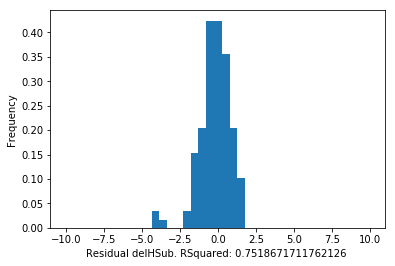

R Squared: 0.7518671711762126
{'alpha': 0.1}


In [2]:
from sklearn import utils
from types import MethodType

with open( "../../model_data/solubility_gm.p", 'rb' ) as f:
    (training_fp1, training_gm1, training_y, test_fp1, test_gm1, test_y,  _, _
    ) = pickle.load( f )

# Fit with parameter selection based on 5-fold cross validation
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]}
model = GridSearchCV(KernelRidge(kernel='precomputed'), 
                   cv=5, param_grid=param_grid)
model.fit(
        training_gm1,  
        training_y,  # dependent values, to be predicted
        # weights=, metric=
)

predicted  = model.predict( test_gm1 )
residuals = test_y - predicted
# rmse = math.sqrt(mean_squared_error(y, predicted))
rsquare = r2_score(test_y,predicted)

# display results
plt.figure()
plt.xlabel('Residual delHSub. RSquared: {} '.format(rsquare))
plt.ylabel('Frequency')
plt.hist(residuals, bins=numpy.linspace(-10, 10, 40), normed=1)
plt.show()
print('R Squared: {}'.format(  rsquare ))
print(model.best_params_)

In [7]:
# log solubilities

df = pandas.read_csv('../../raw_data/solubility.csv')
df['molecule'] = df['SMILES'].apply(Chem.MolFromSmiles)
df.dropna(subset=['molecule']) # ignore any that can't be built
df = df.drop('ESOL predicted log(solubility:mol/L)', axis=1)
df = df.rename(columns={'measured log(solubility:mol/L)':'y'})
#print(len(df))
#to_drop = df['SMILES']=='CCCCCBr'
#df = df[ ~to_drop ]

training_set, test_set = train_test_split(df, test_size=0.1,
    random_state=0 # fixed seed if we want to compare performance later    
)
training_y = training_set['y']
test_y = test_set['y']

def gram_matrix(X, Y=None, sim=DataStructs.FingerprintSimilarity):
    if Y:
        pass
    else:
        Y = X
    gm = numpy.zeros([len(X), len(Y)], dtype=numpy.float64) 
    for i in range(0, len(X)):
        for j in range(0, len(Y)):
            gm[i, j] =  sim(X[i],Y[j])
    return numpy.array(gm, dtype=numpy.float64)


training_m = training_set['molecule']
test_m = test_set['molecule']
# later we do:
#training_m = training_m.apply(rdmolops.AddHs)
#test_m = test_m.apply(rdmolops.AddHs)


param_grid = {"alpha": [1000, 10, 1e-1, 1e-2, 1e-3, 1e-5, 1e-7, 1e-9, 1e-11]}
def get_r2(fp):
    training_fp = list( training_m.apply(fp) )
    test_fp = list( test_m.apply(fp) )
    #for sim in Kernel.MoleculeKernel.SIMILARITIES:    
    training_gm = gram_matrix(training_fp, training_fp, sim=sim)
    test_gm = gram_matrix(test_fp, training_fp, sim=sim)
    model = GridSearchCV(KernelRidge(kernel='precomputed'), 
                       cv=5, param_grid=param_grid)
    model.fit(
            training_gm,  
            training_y,  
    )
    #assert param_grid['alpha'][0]!=model.best_params_['alpha'] and \
    #    param_grid['alpha'][-1]!=model.best_params_['alpha'] ,\
    #    'Alpha may not be optimized: {}'.format(model.best_params_['alpha'])
    if model.best_params_['alpha']==param_grid['alpha'][0] or model.best_params_['alpha']==param_grid['alpha'][-1] :
        print("Alpha not optimised: {}".format( model.best_params_['alpha'] )  )
    predicted  = model.predict( test_gm )
    residuals = test_y - predicted
    return r2_score(test_y,predicted)

training_set.head()

Compound ID      y                                   SMILES  \
706        gentisin -2.943       c1c(O)C2C(=O)C3cc(O)ccC3OC2cc1(OC)   
568        Dialifos -6.340  CCOP(=S)(OCC)SC(CCl)N2C(=O)c1ccccc1C2=O   
571        Diazinon -3.640         CCOP(=S)(OCC)Oc1cc(C)nc(n1)C(C)C   
64   1-Bromopentane -3.080                                  CCCCCBr   
708         glucose  0.740                     OCC1OC(O)C(O)C(O)C1O   

                                             molecule  
706  <rdkit.Chem.rdchem.Mol object at 0x7f8b42111ad0>  
568  <rdkit.Chem.rdchem.Mol object at 0x7f8b4210ee90>  
571  <rdkit.Chem.rdchem.Mol object at 0x7f8b4210ef80>  
64   <rdkit.Chem.rdchem.Mol object at 0x7f8b42162d50>  
708  <rdkit.Chem.rdchem.Mol object at 0x7f8b42111b70>

In [4]:

SIMILARITIES = [ e[1] for e in DataStructs.similarityFunctions if "Sokal" not in e[0]]

FINGERPRINTS = [  
        rdmolops.PatternFingerprint, # NOTE: This function is experimental. The API or results may change from release to release.
        Chem.rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect,
        Chem.rdMolDescriptors.GetMACCSKeysFingerprint,
    
    # these are handled later because they need a parameter sweep
        #Chem.rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect,
        # Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect 
        # Chem.rdmolops.LayeredFingerprint,   
        #rdmolops.RDKFingerprint,     
]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    for fp in FINGERPRINTS:    
        print(fp.__name__)
        training_fp = list( training_m.apply(fp) )
        test_fp = list( test_m.apply(fp) )
        for sim in SIMILARITIES:    
            model = GridSearchCV(KernelRidge(kernel='precomputed'), 
                               cv=5, param_grid=param_grid)
            #training_gm = gram_matrix(training_fp, training_fp, sim=sim)
            #test_gm = gram_matrix(test_fp, training_fp, sim=sim)
            print(sim.__name__, get_r2(fp))
        print()
'Done'

PatternFingerprint
TanimotoSimilarity 0.8991007559460016
DiceSimilarity 0.8632442588060053
CosineSimilarity 0.8505013456854758
RusselSimilarity 0.8444067629095467
RogotGoldbergSimilarity 0.8796670053032811
AllBitSimilarity 0.8518584404784129
KulczynskiSimilarity 0.5902563763162474
McConnaugheySimilarity -1.7573955642596024
AsymmetricSimilarity -33.577019774386535
BraunBlanquetSimilarity 0.8667485463804744

GetHashedTopologicalTorsionFingerprintAsBitVect
TanimotoSimilarity 0.7853393582578401
DiceSimilarity 0.7725081897158658
CosineSimilarity 0.7461778975302993
RusselSimilarity 0.6878722646380521
RogotGoldbergSimilarity 0.7817039542074733
AllBitSimilarity 0.7065184509395426
KulczynskiSimilarity 0.3818918051684953
McConnaugheySimilarity -0.031816126864320005
AsymmetricSimilarity 0.30750801319188026
BraunBlanquetSimilarity 0.7743014468223712

GetMACCSKeysFingerprint
TanimotoSimilarity 0.8132819065437574
DiceSimilarity 0.7097119715425608
CosineSimilarity 0.7028013356934995
RusselSimilarity 

'Done'

Tanimoto similarity outperforms the others, so let's stick with that.

## Parameterized fingerprints
Some fingerprints take optional or required parameters to configure them. Let's try different values. 

### Fingerprints that are less sensitive to tautomers.

In [5]:
sim = DataStructs.FingerprintSimilarity  # Tanimoto is default

print('LayeredFingerprintAsBitVect')
# NOTE: This function is experimental. The API or results may change from release to release.
for maxLength in range(8, 11):    
    for minLength in range(1, 3):
        # note that branchedPaths=False can lead to segfaults
        kwargs = {'maxPath': maxLength, 'minPath': minLength}
        fp = lambda m: Chem.rdmolops.LayeredFingerprint(m, layerFlags=0x1d, **kwargs)
        print(kwargs, get_r2(fp))

print('RDKFingerprint')
for maxPath in range(8, 10):    # with 11 it can segfault
    for minPath in range(1, 2):  # with 3 it can segfault
        # note that branchedPaths=False can lead to segFaults
        kwargs = {'maxPath': maxPath, 'minPath': minPath, 'useHs': False, 
                  'useBondOrder':False}
        fp = lambda m: Chem.rdmolops.RDKFingerprint(m, **kwargs)
        print(kwargs, get_r2(fp))

            
print('GetHashedAtomPairFingerprintAsBitVect')
for maxLength in range(8, 10):    
    for minLength in range(1, 4):
        kwargs = {'maxLength': maxLength, 'minLength': minLength}
        fp = lambda m: Chem.rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(m, **kwargs)
        print(kwargs, get_r2(fp))

        
print('GetMorganFingerprintAsBitVect')
for radius in range(5, 8):
    fp = lambda m: Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius, useBondTypes=False)
    print(radius, get_r2(fp))   
'Done'

LayeredFingerprintAsBitVect
{'maxPath': 8, 'minPath': 1} 0.8407296473419962
{'maxPath': 8, 'minPath': 2} 0.8378604672899563
{'maxPath': 9, 'minPath': 1} 0.854827665153527
{'maxPath': 9, 'minPath': 2} 0.8508941414517223
{'maxPath': 10, 'minPath': 1} 0.853078054488634
{'maxPath': 10, 'minPath': 2} 0.8494672585857221
RDKFingerprint
{'maxPath': 8, 'minPath': 1, 'useHs': False, 'useBondOrder': False} 0.8260824232312053
{'maxPath': 9, 'minPath': 1, 'useHs': False, 'useBondOrder': False} 0.8342430530783709
GetHashedAtomPairFingerprintAsBitVect
{'maxLength': 8, 'minLength': 1} 0.8530753041335509
{'maxLength': 8, 'minLength': 2} 0.8570406544071838
{'maxLength': 8, 'minLength': 3} 0.7995097313275903
{'maxLength': 9, 'minLength': 1} 0.8510324416383165
{'maxLength': 9, 'minLength': 2} 0.8553101403153275
{'maxLength': 9, 'minLength': 3} 0.7969499059149949
GetMorganFingerprintAsBitVect
Alpha not optimised: 1e-09
5 0.8183818234929663
Alpha not optimised: 1e-09
6 0.8225947997898144
Alpha not optimised

'Done'

### Tautomer sensitive fingerprints

In [8]:
# 2D Pharmacophore fingerprint needs too much config
# TODO optimise nBitsPerHash/nBitsPerEntry

training_m = training_m.apply(rdmolops.AddHs)
test_m = test_m.apply(rdmolops.AddHs)

print('LayeredFingerprintAsBitVect')
# NOTE: This function is experimental. The API or results may change from release to release.
for maxLength in range(8, 11):    
    for minLength in range(1, 3):
        # note that branchedPaths=False can lead to segfaults
        kwargs = {'maxPath': maxLength, 'minPath': minLength}
        fp = lambda m: Chem.rdmolops.LayeredFingerprint(m, layerFlags=0x3f, **kwargs)
        print(kwargs, get_r2(fp))

print('GetMorganFingerprintAsBitVect')
for radius in range(5, 8):
    fp = lambda m: Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius, useBondTypes=False)
    print(radius, get_r2(fp))   
    

print('GetHashedAtomPairFingerprintAsBitVect')
for maxLength in range(8, 10):    
    for minLength in range(1, 3):
        kwargs = {'maxLength': maxLength, 'minLength': minLength}
        fp = lambda m: Chem.rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(m, **kwargs)
        print(kwargs, get_r2(fp))


print('RDKFingerprint')
for maxPath in range(8, 11):     
    for minPath in range(1, 3):   
        for branchedPaths in [True]:  # false leads to segfault
            kwargs = {'maxPath': maxPath, 'minPath': minPath, 'useHs': False, 
                      'branchedPaths': branchedPaths, 'useBondOrder':False}
            fp = lambda m: Chem.rdmolops.RDKFingerprint(m, **kwargs)
            print(kwargs, get_r2(fp))
'done'

LayeredFingerprintAsBitVect
{'maxPath': 8, 'minPath': 1} 0.8913610072795681
{'maxPath': 8, 'minPath': 2} 0.8888735026165729
{'maxPath': 9, 'minPath': 1} 0.902216688028896
{'maxPath': 9, 'minPath': 2} 0.8994188208998277
{'maxPath': 10, 'minPath': 1} 0.8726420137785752
{'maxPath': 10, 'minPath': 2} 0.8708187296077322
GetMorganFingerprintAsBitVect
5 0.8479029273732253
6 0.8540649013488184
7 0.8519374006543456
GetHashedAtomPairFingerprintAsBitVect
{'maxLength': 8, 'minLength': 1} 0.8778952075799127
{'maxLength': 8, 'minLength': 2} 0.87640657273631
{'maxLength': 9, 'minLength': 1} 0.8788129881642012
{'maxLength': 9, 'minLength': 2} 0.8750701364916379
RDKFingerprint
{'maxPath': 8, 'minPath': 1, 'useHs': False, 'branchedPaths': True, 'useBondOrder': False} 0.8260824232312053
{'maxPath': 8, 'minPath': 2, 'useHs': False, 'branchedPaths': True, 'useBondOrder': False} 0.8211837420113829
{'maxPath': 9, 'minPath': 1, 'useHs': False, 'branchedPaths': True, 'useBondOrder': False} 0.8342430530783709
{

'done'

In [9]:
get_r2(rdmolops.PatternFingerprint) # NOTE: This function is experimental. The API or results may change from release to release.
#        Chem.rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect,
#        Chem.rdMolDescriptors.GetMACCSKeysFingerprint,)

0.8912954117081374



[Up](Welcome.ipynb) [Support Vector Classification](SVC.ipynb) [Previous](Kernels.ipynb)

Copyright STFC 2018